In [1]:
!ps -U DZHeglov --no-headers -o rss | awk '{ sum+=$1} END {print int(sum/1024) "MB"}'
!ps -U DAMudrov --no-headers -o rss | awk '{ sum+=$1} END {print int(sum/1024) "MB"}'
!ps -U EDTolstov --no-headers -o rss | awk '{ sum+=$1} END {print int(sum/1024) "MB"}'
!ps -U LILitvinova --no-headers -o rss | awk '{ sum+=$1} END {print int(sum/1024) "MB"}'
!ps -U AVKaledin --no-headers -o rss | awk '{ sum+=$1} END {print int(sum/1024) "MB"}'

!free -m

228MB
11626MB
8709MB
14522MB
3431MB
              total        used        free      shared  buff/cache   available
Mem:         128532       45583       76597        2626        6351       78680
Swap:          8191        7067        1124


In [2]:
from networkit import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from pyhive import hive

In [3]:
hive_options = {                'mapreduce.job.reduces': '200',
                'hive.exec.parallel.thread.number': '16',
                'hive.cli.print.header': 'true',
                'hive.exec.dynamic.partition.mode': 'nonstrict',
                'hive.exec.dynamic.partition': 'true',
                'hive.exec.parallel': 'true',
                'hive.cli.print.current.db': 'true',
                'hive.auto.convert.join': 'false',
                'hive.resultset.use.unique.column.names': 'false'
               }
conn = hive.Connection(host = "hd-has014.vimpelcom.ru", port = "10000", username = "AVKaledin", 
                       auth = "KERBEROS", kerberos_service_name = "hive", configuration = hive_options)
cursor = conn.cursor()

INFO:pyhive.hive:USE `default`


## Take data

HQL query in https://servicedesk.veon.com/browse/CVM-302

In [4]:
q = '''select 
ctn
,topid as top_id
,ctn_a
,ctn_b
,all_calls_count
from cvm_stg.ansp_top_contacts_network_02
''' 
q = q.replace('\n',' ')
q

'select  ctn ,topid as top_id ,ctn_a ,ctn_b ,all_calls_count from cvm_stg.ansp_top_contacts_network_02 '

In [5]:
data = pd.read_sql(q, conn)

INFO:pyhive.hive:select  ctn ,topid as top_id ,ctn_a ,ctn_b ,all_calls_count from cvm_stg.ansp_top_contacts_network_02 


In [6]:
#data.to_csv('data/data_b2c.csv', index=False)

Take from csv

In [7]:
#data = pd.read_csv('data/data_b2c.csv')
data.head()

ctn      top_id    ctn_a   ctn_b all_calls_count
0  9650388306  8124492299   810237  281183               1
1  9602515000  8124492299  1035670  281183               2
2  9650078837  8124492299   565038  281183               4
3  9219744001  8124492299   170964  281183               2
4  9095791639  8124492299    45951  281183               4

## Create graph

In [8]:
# join & count 
unique_ctn = pd.Series(np.concatenate((data.ctn_a,data.ctn_b))).unique()

In [9]:
# we can save this info
print('Vertices (nodes) =', unique_ctn.shape[0])
print('Edges            =', data.shape[0])

Vertices (nodes) = 1198480
Edges            = 4341057


In [10]:
#transform object type to int
data['all_calls_count'] = data['all_calls_count'].astype(int)

In [11]:
#create networKit Graph
G = None
G = Graph(unique_ctn.shape[0]
         ,weighted = True
         ,directed = False)

for i in range(data.shape[0]):
    G.addEdge(data.loc[i,'ctn_a'], data.loc[i,'ctn_b'], data.loc[i,'all_calls_count'])
    if i % 100000 == 0:
        print(i,' transactions are done')
overview(G)

0  transactions are done
100000  transactions are done
200000  transactions are done
300000  transactions are done
400000  transactions are done
500000  transactions are done
600000  transactions are done
700000  transactions are done
800000  transactions are done
900000  transactions are done
1000000  transactions are done
1100000  transactions are done
1200000  transactions are done
1300000  transactions are done
1400000  transactions are done
1500000  transactions are done
1600000  transactions are done
1700000  transactions are done
1800000  transactions are done
1900000  transactions are done
2000000  transactions are done
2100000  transactions are done
2200000  transactions are done
2300000  transactions are done
2400000  transactions are done
2500000  transactions are done
2600000  transactions are done
2700000  transactions are done
2800000  transactions are done
2900000  transactions are done
3000000  transactions are done
3100000  transactions are done
3200000  transactions a

In [12]:
overview(G)

Network Properties for:		G#3
nodes, edges			1198480, 4341057
directed?			False
weighted?			True
isolated nodes			1
self-loops			3644
density				0.000006
min/max/avg degree		0, 10338, 7.241230
degree assortativity		-0.006069
number of connected components	12383
size of largest component	1169909 (97.62 %)


In [13]:
#writeGraph(G, "output/G_b2c.graph", Format.METIS)
#не поддерживается в Gephi и не получилось нормально считать на текущем датасете

In [14]:
#writeGraph(G,"output/G.edgelist", Format.EdgeListSpaceOne)

## Use graph

In [15]:
#works, but other num of Edges
#Gr = readGraph("output/G.edgelist", Format.EdgeListSpaceOne)

In [16]:
#num of comp and pairs
cc = components.ConnectedComponents(G)
cc.run()
#print("number of components ", cc.numberOfComponents())
#v = 0
#print("component of node ", v , ": " , cc.componentOfNode(0))
#print("map of component sizes: ", cc.getComponentSizes())

In [17]:
# Vertices & Edges
V = G.nodes()
#print(V[:10])
E = G.edges()
#print(E[:100])

## SNA

### Degree centrality

Степень центральности (Degree centrality) – показывает, кто является наиболее активным узлом в сети. Измеряется количеством связей с другими узлами в сети. Центральность показывает, насколько данный узел близок по отношению к другим узлам в сети. Большое количество взаимодействий узла может не только изменить позицию узла в сети, но также и изменить позиции других узлов.

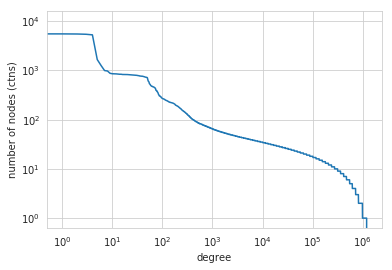

In [18]:
dd = sorted(centrality.DegreeCentrality(G).run().scores(), reverse=True)
plt.xscale("log")
plt.xlabel("degree")
plt.yscale("log")
plt.ylabel("number of nodes (ctns)")
plt.plot(dd)
plt.show()

In [19]:
#abc = centrality.ApproxBetweenness(G, epsilon=0.1)
#abc.run()

In [20]:
#abc.ranking()[:10]

In [21]:
degree_scores = centrality.DegreeCentrality(G)
degree_scores.run()

In [22]:
degree_scores_pandas = pd.DataFrame(degree_scores.ranking(), columns=['ctn', 'DegreeCentrality'])
degree_scores_pandas.head()

ctn  DegreeCentrality
0   434156           10338.0
1   557013            5511.0
2   611436            5483.0
3   148927            5414.0
4  1145066            5271.0

In [23]:
#visualize
#coreDec = centrality.CoreDecomposition(G)
#coreDec.run()

In [24]:
#viztasks.drawGraph(G, nodeSizes=[(k**2)*20 for k in coreDec.scores()])
#plt.show()

### Detect communities

Community detection is concerned with identifying groups of nodes which are significantly more densely connected to each other than to the rest of the network.

Code for community detection is contained in the community module. The module provides a top-level function to quickly perform community detection with a suitable algorithm and print some stats about the result.

In [25]:
Communities = community.detectCommunities(G, algo=community.PLM(G, True))

PLM(balanced,refine,pc,turbo) detected communities in 3.044344186782837 [s]
solution properties:
-------------------  ------------
# communities        12789
min community size       1
max community size   29188
avg. community size     93.7118
modularity               0.871872
-------------------  ------------


In [26]:
community.writeCommunities(Communities, "output/communities_b2c_1.partition")

wrote communities to: output/communities_b2c_1.partition


In [27]:
#read the saved file with the function pandas.read_csv and remove the header and the index
df_communities = pd.read_csv("output/communities_b2c_1.partition", header=None).reset_index()
#Rename the columns
df_communities.columns = ["Element_ID","Community_ID"]

In [28]:
df_communities['Community_ID'].value_counts().head()

47    29188
42    28034
44    27562
33    26146
78    23610
Name: Community_ID, dtype: int64

In [29]:
df_communities[df_communities['Community_ID'] == 9].head()

Element_ID  Community_ID
9             9             9
174         174             9
338         338             9
375         375             9
717         717             9

In [30]:
communities_count = df_communities.groupby(by=['Community_ID'], as_index=False).count()

In [31]:
import seaborn as sns

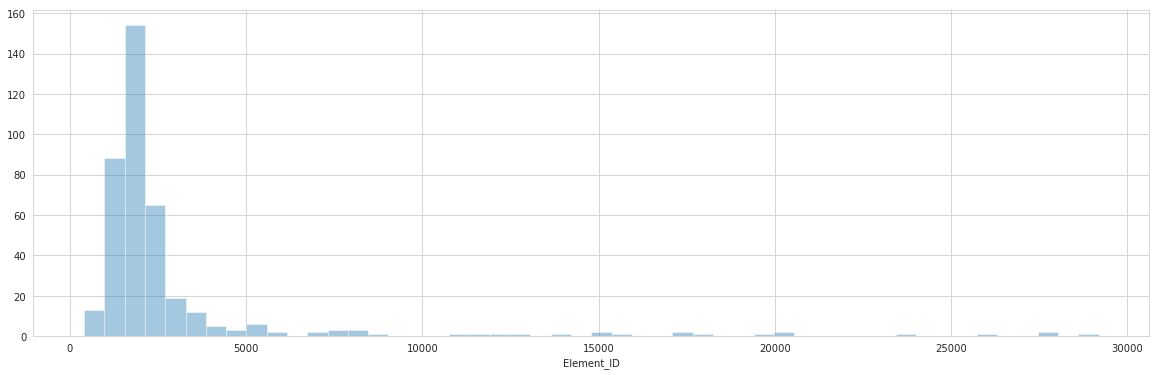

In [32]:
#community sizes
plt.figure(figsize=[20,6])
sns.distplot(communities_count[communities_count['Element_ID']>100]['Element_ID'], kde=False)
plt.show()

In [33]:
#communities_count[communities_count['Element_ID']>100]['Element_ID'].describe()

### Join

In [34]:
ctn_community_table = pd.merge(left = degree_scores_pandas
                              , right = df_communities
                              , left_on = ['ctn']
                              , right_on = ['Element_ID']
                              , how = 'inner'
                              )
ctn_community_table.drop(columns='Element_ID', inplace=True)
ctn_community_table.head()

ctn  DegreeCentrality  Community_ID
0   434156           10338.0           113
1   557013            5511.0            17
2   611436            5483.0            17
3   148927            5414.0            17
4  1145066            5271.0            17

In [35]:
len(communities_count[communities_count['Element_ID']>1000]['Community_ID'].unique())

379

In [36]:
big_communities = communities_count[communities_count['Element_ID']>1000]['Community_ID'].unique()

In [37]:
ctn_community_table[ctn_community_table['Community_ID'].isin(big_communities)].head()

ctn  DegreeCentrality  Community_ID
0   434156           10338.0           113
1   557013            5511.0            17
2   611436            5483.0            17
3   148927            5414.0            17
4  1145066            5271.0            17

In [38]:
comm_max = ctn_community_table.groupby(['Community_ID'], sort=False)['DegreeCentrality'].max().reset_index()

In [39]:
comm_max.columns = ['Community_ID', 'MaxDegree']
comm_max.head()

Community_ID  MaxDegree
0           113    10338.0
1            17     5511.0
2           209     1658.0
3           253      972.0
4           410      873.0

Create Leader's flag

In [40]:
final = ctn_community_table.merge(comm_max, on='Community_ID')

In [41]:
final['Leader'] = 0

In [42]:
#num of big communities is not so big, so imho we can use isin
final.loc[final[(final['Community_ID'].isin(big_communities)) & (final['DegreeCentrality'] == final['MaxDegree'])].index, 'Leader'] = 1

In [43]:
final[final['Leader'] == 1].shape

(386, 5)

In [44]:
ctn_community_table[ctn_community_table['Community_ID'] == 192].sort_values(by = ['DegreeCentrality'], ascending=False).head(3)

ctn  DegreeCentrality  Community_ID
7399   487389              37.0           192
10334  257524              34.0           192
13974  778774              32.0           192

### Back 2 original ctn

In [45]:
final[final['Leader'] == 1].head()

ctn  DegreeCentrality  Community_ID  MaxDegree  Leader
0      434156           10338.0           113    10338.0       1
8927   557013            5511.0            17     5511.0       1
23876   68884            1658.0           209     1658.0       1
29356   89283             972.0           253      972.0       1
31858  307295             873.0           410      873.0       1

In [62]:
#data[['ctn_a', 'ctn_b']]

In [66]:
data_final = data.drop_duplicates(subset='top_id').merge(final[final['Leader'] == 1], left_on = 'ctn_b', right_on = 'ctn')

In [67]:
data_final.shape

(386, 10)

In [68]:
#data_final = data.drop_duplicates(subset='ctn').merge(final[final['Leader'] == 1], left_on = 'ctn_a', right_on = 'ctn')

In [73]:
data_final = data_final[['top_id', 'all_calls_count', 'DegreeCentrality', 'Community_ID', 'MaxDegree', 'Leader']]

In [76]:
data_final.columns = [['ctn', 'all_calls_count', 'DegreeCentrality', 'Community_ID', 'MaxDegree', 'Leader']]

In [77]:
data_final.head()

ctn all_calls_count DegreeCentrality Community_ID MaxDegree Leader
0  9643421384               2             64.0           67      64.0      1
1  9681887287               1            169.0          299     169.0      1
2  9052039036               1            301.0          304     301.0      1
3  9650755070               1            136.0           86     136.0      1
4  9052118670               3             48.0           14      48.0      1

In [72]:
data_final.shape

(386, 7)

In [46]:
#save leaders info
data_final.to_csv('data/top_id_leaders_2.csv', index = False)

In [47]:
#output -> 407 subs
#executed in 543ms, finished 13:58:33 2019-06-07

## Next Steps

* Undirected graphs;
* Weekend data;
* GraphSAGE https://github.com/williamleif/GraphSAGE